In [1]:
import numpy as np
import neptune
import imageio
import scipy as scipy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import skimage as skim
from tqdm import tqdm as tqdm

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from src.data_generator import ShiftedDataBatcher
from src.data_loader import _shift_image
from src.test_models.crduplex import CRDuplex
from src.utils import save_model, save_model_and_weights, save_weights, prepare_dir
from src.plot import plot_img_row,remove_axes,remove_labels

Using TensorFlow backend.


# Experiment parameters

In [2]:
exp_date = '2020-04-10'
proj_root = '/home/elijahc/projects/vae'
models_root = prepare_dir(proj_root,'models',exp_date)

In [3]:
PROPS = {
    'dataset':'fashion_mnist',
    'encoder_arch': 'convnet',
    'generator_arch': 'resnet',
    'augmentation': 'dynamic',
}

PARAMS = {}

train_conf = {
    'n_epochs': 90000,
    'batch_sz':256,
}

data_conf = {
    'bg': 'natural',
    'im_translation':0.75,
    'bg_contrast': 1.0,
    'rotation':0.3,
}

model_conf = {
    'xent_weight': 15,
    'recon_weight': 0.0625,
    'y_dim':500,
    'z_dim':0,
}

for conf in [train_conf,data_conf,model_conf]:
    PARAMS.update(conf)

# Initialize databatcher with experiment parameters

In [4]:
DB = ShiftedDataBatcher(PROPS['dataset'],translation=PARAMS['im_translation'],bg=PARAMS['bg'],
                        blend=None,
                        scale=4,
                        rotation=PARAMS['rotation'],
#                         blend='difference',
                        batch_size=PARAMS['batch_sz'],
                       )

loading bsds500...


In [5]:
x,fg,y = next(DB.gen_train_batches(1))

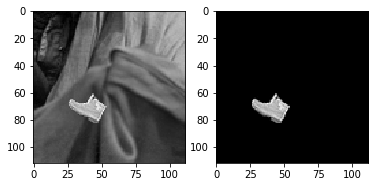

In [6]:
x,fg,y = DB.plot_example()

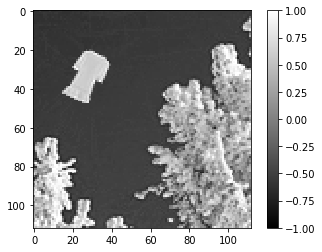

In [7]:
plt.imshow(x[5].reshape(112,112),cmap='gray',vmin=-1,vmax=1)
plt.colorbar()

# Initialize neptune monitoring

In [8]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')

Project(elijahc/DuplexAE)

In [9]:
neptune.init('elijahc/DuplexAE')
src_files = [
    './src/data_generator.py',
    './src/data_loader.py',
    './src/utils.py',
    './src/test_models/crduplex.py',
    './src/test_models/partials.py',
    './src/test_models/encoders.py',
]
exp = neptune.create_experiment(name='Lg_convE_w_recon',properties=PROPS,params=PARAMS,upload_source_files=src_files)
exp_dir = os.path.join('models',exp_date,exp.id)
exp.set_property('dir',exp_dir)

https://ui.neptune.ml/elijahc/DuplexAE/e/DPX-41


Experiment(DPX-41)

In [10]:
prepare_dir(proj_root,exp_dir)
prepare_dir(proj_root,exp_dir,'recons')
prepare_dir(proj_root,exp_dir,'test_ims')

/home/elijahc/projects/vae/models/2020-04-10/DPX-41  does not exist. Creating...
/home/elijahc/projects/vae/models/2020-04-10/DPX-41/recons  does not exist. Creating...
/home/elijahc/projects/vae/models/2020-04-10/DPX-41/test_ims  does not exist. Creating...


'/home/elijahc/projects/vae/models/2020-04-10/DPX-41/test_ims'

In [11]:
w_xent = PARAMS['xent_weight']
w_recon = PARAMS['recon_weight']

In [40]:
from src.test_models.partials import GResNet

In [ ]:
GResNet()

In [12]:
mod = CRDuplex(img_shape=(112,112,1),y_dim=PARAMS['y_dim'],z_dim=PARAMS['z_dim'],
               num_classes=DB.num_classes,
               recon=w_recon,
               xent=w_xent,n_residual_blocks=4,
#                kernel_regularization=1e-5,
              )

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
mod_dir = prepare_dir(proj_root,exp_dir)
mod_dir

'/home/elijahc/projects/vae/models/2020-04-10/DPX-41'

# Save model description and initial weights

In [14]:
save_model(mod.combined,mod_dir)
mod.combined.save_weights(os.path.join(mod_dir,'weights_0.h5'))

model_json = mod.combined.to_json()
with open(os.path.join(mod_dir,"model.json"), "w") as json_file:
    json_file.write(model_json)

In [15]:
mod.combined.metrics_names

['loss',
 'Generator_loss',
 'Classifier_loss',
 'Generator_mean_squared_error',
 'Classifier_acc']

In [16]:
# val_pct = 0.05
# val_idxs = np.random.choice(np.arange(10000),int(val_pct*60000),replace=False)
# validation_set = (DB.x_te[val_idxs],
#                   {'Classifier':DB.y_test_oh[val_idxs],
#                    'Generator':DB.fg_test[val_idxs]}
#                  )

In [17]:
i = 0
epoch_sz = int(DB.num_train/512)
pan_ims = []
pan_y = []

# hist_labels = mod.combined.metrics_names
hist_labels = ['loss','G_loss','C_loss','G_mse','acc']

train_hist = []
test_hist = []

# val_X,val_X_fg,val_y = DB.gen_batch(DB.x_te,DB.y_test_oh,batch_size=1000,bg='natural')

In [18]:
test_generator = DB.gen_test_batches(1, batch_size=PARAMS['batch_sz'])
tX, tX_fg,ty = next(test_generator)

In [19]:
num_pan = 3
# test_generator = DB.gen_test_batches(4, batch_size=PARAMS['batch_sz'], bg=PARAMS['bg'])
not_unique = True
while not_unique:
    pan_idx = np.random.choice(np.arange(len(DB.x_te)),size=num_pan,replace=False)
    if len(np.unique(DB.y_test[pan_idx])) == num_pan:
        not_unique = False
    
px_ = np.expand_dims(DB.x_te[pan_idx],-1)
print(px_.shape)


(3, 28, 28, 1)


In [20]:
# import numpy as np
# nj = 25
# fig,axs = plt.subplots(1,nj,figsize=(2*nj,2))

# for i in np.arange(nj):
#     axs[i].imshow(pX[i+15].reshape(56,56))

In [21]:
def flush_pan(pan_ims):
    min_max = lambda xp: np.clip((xp+1)/2,0,1)
    for idx,inp,G in pan_ims:
        idx = str(idx).zfill(3)
        
#         inp_fn = 'input_{}.png'.format(idx)
#         inp_fp = os.path.join(proj_root,exp_dir,'test_ims',inp_fn)
        
        G_fn = 'G_{}.png'.format(idx)
        G_fp = os.path.join(proj_root,exp_dir,'recons',G_fn)
    
        fig,axs = plt.subplots(2,num_pan)
        for k in np.arange(num_pan):
            axs[0,k].imshow(inp[k],cmap='gray')
            axs[1,k].imshow(G[k],cmap='gray')

        for ax in axs.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.tight_layout()     
        
        fig.savefig(G_fp)
        plt.close(fig)

In [22]:
recon_dir = prepare_dir(proj_root,exp_dir,'recons')
input_dir = prepare_dir(proj_root,exp_dir,'test_ims')

In [23]:
def make_gif(recon_dir,input_dir,fps=8,loop=0):
    G_ims = []
    for G in sorted(os.listdir(recon_dir)):
        if G.endswith('.png'):
            G_fp = os.path.join(recon_dir, G)
            G_ims.append(imageio.imread(G_fp))
        
#     imageio.mimsave(os.path.join(proj_root,exp_dir,'inputs_video.gif'), input_ims,fps=fps,loop=loop)
    imageio.mimsave(os.path.join(proj_root,exp_dir,'G_video.gif'), G_ims, fps=fps,loop=loop)

In [24]:
# x_span = DB.gen_pan_deltas(step=2)
# pX = np.stack([DB._translate_image(px_[1],dx,dy) for dx,dy in x_span])



# scaler = MinMaxScaler(feature_range=(-1,1))
# n,x,y,c = pX.shape

# pX = scaler.fit_transform(pX.reshape(n,x*y*c)).reshape(n,x,y,c)

In [ ]:
skim.util.random_noise()

In [ ]:
mod.combined.train_on_batch()

In [30]:
pdx = np.linspace(0,112-28,42,dtype=int)
with tqdm(DB.gen_train_batches(PARAMS['n_epochs']), miniters=5, total=PARAMS['n_epochs'],initial=i) as batch:

    for X,X_fg,y in batch:
        y = {'Classifier':y,
             'Generator':X_fg,
            }
        r = mod.combined.train_on_batch(X,y)
        r = {k:v for k,v in zip(hist_labels,r)}

        if i % 50 == 0:
            r_te = mod.combined.test_on_batch(tX,{'Classifier':ty,
                                                  'Generator':tX_fg
                                                 })
            r_te = {k:v for k,v in zip(hist_labels,r_te)}
            exp.log_metric('batch',i)
            for metric in hist_labels:
                exp.log_metric(metric,r[metric])
                exp.log_metric('val_{}'.format(metric),r_te[metric])

            r['batch']=i
            r_te['batch']=i

            r['result_type'] = 'train'
            r_te['result_type'] = 'valid'

            train_hist.append(r)
            train_hist.append(r_te)
            p_epoch = "{:5d} ".format(i)
            p_loss = "loss[G+C]:[{:2.2f}+{:.2f}] / [{:2.2f}+{:.2f}] ".format(r['G_loss'],r['C_loss'],r_te['G_loss'],r_te['C_loss'])
    #         p_loss = "{:5d} (train/val loss:[{:2.2f}, {:2.2f}])".format(i,r['loss'],r_te['loss'])
            p_acc = "acc: [{:02.2%}] / [{:02.2%}] ".format(r['acc'],r_te['acc'])
    #         print('epoch')
#             print(p_epoch, '(train/val) ', p_acc,p_loss)

#             pidx = int(i/epoch_sz)%len(pX)

            
            if i in [50,100,150,300] or i%200 == 0:
#                 im = np.expand_dims(tX[5],0)
                pdx_idx = int((i/100)%len(pdx))
                im = np.expand_dims(DB._translate_image(px_[0],56-14,pdx[pdx_idx]),0)/255.0
                im = DB.scaler.transform(im.reshape(1,-1)).reshape(1,112,112,1)
                n_im = skim.util.random_noise(im,mode='gaussian',var=0.15,mean=-0.1,clip=True,)
                p_recon,p_class = mod.combined.predict_on_batch(n_im)

                batch.set_description('writing_image_buffer...')
                hist_tr = pd.DataFrame.from_records(train_hist)
                fig,axs = plt.subplots(1,4,figsize=(8,2))
                sns.lineplot(x='batch',y='G_loss',hue='result_type',data=hist_tr,ax=axs[0],legend=False)
                axs[0].set_yscale('log')
#                 if len(hist_tr)>150:
#                     axs[0].set_xlim(hist_tr.batch.values[-150],hist_tr.batch.values[-1])
                axs[1].imshow(np.squeeze(n_im),cmap='gray',vmin=-1,vmax=1)
                axs[0].set_title('G_loss: {}'.format(int(r_te['G_loss'])))

                axs[2].imshow(np.squeeze(p_recon),cmap='gray',vmin=-1,vmax=1)
                axs[2].set_title('Acc: {:02.1%} / {:02.1%}'.format(r['acc'],r_te['acc']))

                axs[3].imshow(np.squeeze(im),cmap='gray', vmin=-1,vmax=1)

                for ax in axs[1:].ravel():
                    remove_labels(ax)
                    remove_axes(ax)
                
                plt.tight_layout()
                fig.savefig(os.path.join(recon_dir,'recon_{}.png'.format(str(i).zfill(5))))
                plt.close(fig)
#                 subprocess.run(['convert', '-delay', '20', '-loop', '0', '*.png', 'recon_learning.gif'])
#                 url = subprocess.run(['imgur-uploader', 'recon_learning.gif',],stdout=subprocess.PIPE).stdout.decode('utf-8')
#                 exp.set_property('recon_gif',url)
                
            batch.set_description(p_epoch + '(train/val) ' + p_acc + p_loss)

        i+=1

76400 (train/val) acc: [50.00%] / [56.25%] loss[G+C]:[122.93+1.38] / [92.42+1.24] :  85%|████████▍ | 76428/90000 [00:31<2:24:14,  1.57it/s]


KeyboardInterrupt: 

In [ ]:
X,X_fg,y = next(DB.gen_train_batches(PARAMS['n_epochs'],bg=PARAMS['bg']))

In [ ]:
flush_pan(pan_ims)
pan_ims = []
make_gif(recon_dir,input_dir,)

In [31]:
mod_dir = os.path.join(proj_root,exp_dir)
mod_dir

'/home/elijahc/projects/vae/models/2020-04-10/DPX-41'

In [32]:
hist_tr = pd.DataFrame.from_records(train_hist)

In [ ]:
# sns.set_context('talk')
# fig,axs = plt.subplots(1,4,figsize=(4*4,1*4),sharex=True)
# for ax,metric in zip(axs.ravel(),['loss','G_loss','C_loss','acc']):
#     sns.lineplot(x='batch',y=metric, hue='result_type',data=hist_tr,ax=ax)

In [33]:
print(mod_dir)
hist_tr.to_csv(os.path.join(mod_dir,'training_hist.csv'))

/home/elijahc/projects/vae/models/2020-04-10/DPX-41


In [34]:
model_json = mod.combined.to_json()
with open(os.path.join(mod_dir,"model.json"), "w") as json_file:
    json_file.write(model_json)
    
exp.send_artifact(os.path.join(mod_dir,'model.json'))

In [36]:
exp.stop()

In [35]:
mod.combined.save_weights(os.path.join(mod_dir,'weights.h5'))

In [38]:
mod.G.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GConv_input (InputLayer)        (None, 500)          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3136)         1571136     GConv_input[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 14, 14, 16)   0           dense_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 14, 14, 16)   64          reshape_1[0][0]                  
__________________________________________________________________________________________________
activation

In [ ]:
teX,teX_fg,te_y = next(test_generator)

In [ ]:
res = mod.combined.evaluate(teX,{'Classifier':te_y,'Generator':teX_fg},batch_size=PARAMS['batch_sz'])


In [ ]:
res

In [ ]:
nteX = skim.util.random_noise(teX,mode='gaussian',var=0.2)
nout = mod.combined.predict_on_batch(nteX)

In [ ]:
out = mod.combined.predict_on_batch(teX)
x_recon,y = out
n_recon,ny = nout

In [ ]:
choices = np.random.choice(np.arange(512),size=5,replace=False)

In [ ]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(teX[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    axs[1].imshow(x_recon[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(mod_dir,'inp_output_pairs.png'),dpi=150)

In [ ]:
exp.send_artifact(os.path.join(mod_dir,'inp_output_pairs.png'))

In [ ]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(nteX[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    axs[1].imshow(n_recon[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()